# Project: Building a Proactive Tutoring Bot with a "Success Predictor" Model

**Goal:** Build a machine learning model that can predict a student's likelihood of success on their next problem. This "success probability" will serve as a real-time struggle metric to drive a proactive and intelligent tutoring system.

**Methodology:**
1.  **Data Foundation:** Load and clean data from ASSISTments and KDD Cup by streaming directly from a single data archive.
2.  **Canonical Skill Ontology:** Create a "master" list of skills using semantic embeddings to ensure that skills from different datasets are comparable. This is the core of the model's intelligence.
3.  **Feature Engineering:** Create powerful, leakage-free historical features that capture a student's long-term mastery (`skill_correct_rate`) and short-term performance (`prior_is_correct`).
4.  **Train & Validate "Success Predictor":** Train a LightGBM model to predict the `is_correct` outcome. Validate it on both an internal test set and an external hold-out dataset to confirm its generalization.
5.  **Simulate the Tutor:** Use the trained model to power a simulated tutor, showcasing its ability to provide multi-level, proactive support based on the real-time `prob_of_success`.o generate a `prob_of_success` score for millions of interactions, creating a final, enriched master dataset.

In [27]:
# =================================================================
# PART 1: SETUP, IMPORTS, AND PATHS
# This cell imports all necessary libraries and defines the correct
# relative paths for the entire project.
# =================================================================

# --- Core and Data Libraries ---
import pandas as pd
import numpy as np
import os
import zipfile
import joblib
import io
import re
import torch

# --- Machine Learning Libraries ---
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer, util

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define Relative Paths for the Portable Project Structure ---
# '..' tells the notebook to go UP one level from /notebooks/ to the main project root.
raw_data_dir = '../data/raw/'
output_dir = '../models/'
processed_data_dir = '../data/processed/'
zip_file_path = os.path.join(raw_data_dir, 'Hint_Inference_Project_Data.zip')

# --- Create Output Directories ---
os.makedirs(output_dir, exist_ok=True)
os.makedirs(processed_data_dir, exist_ok=True)

print("Setup complete. Paths are defined.")

Setup complete. Paths are defined.


## Part 2: Data Loading and Cleaning

This section opens the single data archive (`Hint_Inference_Project_Data.zip`) and streams the required CSV files directly into pandas DataFrames. It then cleans the data and standardizes the schemas.


In [28]:
# =================================================================
# PART 2: DATA LOADING AND CLEANING
# =================================================================

print(f"Opening dataset archive: {zip_file_path}")
try:
    # We will keep the zip file object open for loading multiple files
    zip_archive = zipfile.ZipFile(zip_file_path, 'r')
    
    print("Loading datasets directly from ZIP file...")
    
    with zip_archive.open('assistments09.csv') as f:
        df_assistments = pd.read_csv(f, encoding='latin1', low_memory=False)

    with zip_archive.open('kdd_cup_2010_train.tsv') as f:
        df_kdd = pd.read_csv(f, sep='\\t')

    print("All required datasets loaded successfully.")

except FileNotFoundError:
    print("="*60)
    print("ERROR: ZIP file not found!")
    print(f"Please run 'scripts/fetch_datasets.py' script first.")
    print("="*60)
    raise

# --- Schema Unification --- 
def clean_response_time(series, upper_bound_sec=300, is_ms=False):
    series = pd.to_numeric(series, errors='coerce')
    if is_ms: series = series / 1000
    series = series.apply(lambda x: x if x > 0 else np.nan)
    series = series.apply(lambda x: min(x, upper_bound_sec) if pd.notna(x) else x)
    return series

df_assist_clean = df_assistments[['user_id', 'problem_id', 'skill_id', 'skill_name', 'correct', 'ms_first_response', 'hint_count']].copy()
df_assist_clean.rename(columns={'user_id': 'student_id', 'correct': 'is_correct', 'ms_first_response': 'response_time_sec'}, inplace=True)
df_assist_clean['response_time_sec'] = clean_response_time(df_assist_clean['response_time_sec'], is_ms=True)

df_kdd_clean = df_kdd[['Anon Student Id', 'Problem Name', 'KC(Default)', 'Correct First Attempt', 'Step Duration (sec)', 'Hints']].copy()
df_kdd_clean.rename(columns={'Anon Student Id': 'student_id', 'Problem Name': 'problem_id', 'KC(Default)': 'skill_id', 'Correct First Attempt': 'is_correct', 'Step Duration (sec)': 'response_time_sec', 'Hints': 'hint_count'}, inplace=True)
df_kdd_clean['response_time_sec'] = clean_response_time(df_kdd_clean['response_time_sec'], is_ms=False)

print("\nSchema unification complete.")

Opening dataset archive: ../data/raw/Hint_Inference_Project_Data.zip
Loading datasets directly from ZIP file...


C:\Users\Alan\AppData\Local\Temp\ipykernel_34524\4117597919.py:16: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_kdd = pd.read_csv(f, sep='\\t')


All required datasets loaded successfully.

Schema unification complete.


## Part 3: Artifact Creation (Hints and Skill Ontology)

This section creates and saves two critical artifacts that power the rest of the project:
1.  **`structured_hints_database.csv`**: A simulated database of hint content.
2.  **`canonical_skill_mapping.csv`**: The intelligent mapping that translates skills from different datasets into a single, unified ontology using semantic embeddings.

In [29]:
# =================================================================
# PART 3: ARTIFACT CREATION
# =================================================================

# --- 3a. Hint Database Creation ---
print("Building structured hint database...")
simulated_hints_data = {
    'problem_id': [
        'problem_algebra_1', 'problem_algebra_1', 'problem_algebra_1',
        'problem_geometry_1', 'problem_geometry_1',
        'problem_arithmetic_1'
    ],
    'hint_level': [ 1, 2, 3, 1, 2, 1 ],
    'hint_text': [
        "Hint 1/3: Remember to distribute the term outside the parentheses to both terms inside.",
        "Hint 2/3: After distributing, your equation should look like `2x + 6 = 12`. Now isolate 'x'.",
        "Hint 3/3 (Answer): The final answer is x=3.",
        "Hint 1/2: The formula for the area of a triangle is (1/2) * base * height.",
        "Hint 2/2: You have the base and area, so rearrange the formula to solve for the height.",
        "Hint 1/1: Don't forget to carry the one when you add the tens column."
    ]
}
df_hints = pd.DataFrame(simulated_hints_data)
hint_db_path = os.path.join(output_dir, 'structured_hints_database.csv')
df_hints.to_csv(hint_db_path, index=False)
print(f"Hint database saved to {hint_db_path}")

# --- 3b. Canonical Skill Ontology Creation ---
print("\nBuilding canonical skill ontology...")
df_assist_skills = df_assistments[['skill_id', 'skill_name']].copy().dropna().drop_duplicates()
df_assist_skills = df_assist_skills[df_assist_skills['skill_name'] != '']
canonical_skills = df_assist_skills['skill_name'].unique()

kdd_raw_skills = df_kdd['KC(Default)'].dropna().unique()
kdd_skills = sorted(list(set([s.split('~~')[0].strip() for s in kdd_raw_skills])))

print("Loading sentence embedding model (this may take a moment)...")
model = SentenceTransformer('all-MiniLM-L6-v2')
canonical_embeddings = model.encode(canonical_skills, convert_to_tensor=True)
kdd_embeddings = model.encode(kdd_skills, convert_to_tensor=True)

print("Mapping KDD skills to canonical ontology...")
cos_scores = util.cos_sim(kdd_embeddings, canonical_embeddings)
kdd_to_assistments_map = {}
for i, kdd_skill_text in enumerate(kdd_skills):
    best_match_index = torch.argmax(cos_scores[i]).item()
    kdd_to_assistments_map[kdd_skill_text] = canonical_skills[best_match_index]

df_map1 = df_assist_skills.rename(columns={'skill_id': 'original_skill_id', 'skill_name': 'canonical_skill_name'})
df_map1['source'] = 'assistments'
df_map2 = pd.DataFrame(list(kdd_to_assistments_map.items()), columns=['original_skill_id', 'canonical_skill_name'])
df_map2['source'] = 'kdd'
df_skill_mapping = pd.concat([df_map1, df_map2], ignore_index=True)

mapping_path = os.path.join(output_dir, 'canonical_skill_mapping.csv')
df_skill_mapping.to_csv(mapping_path, index=False)
print(f"Canonical skill mapping saved to {mapping_path}")

Building structured hint database...
Hint database saved to ../models/structured_hints_database.csv

Building canonical skill ontology...
Loading sentence embedding model (this may take a moment)...
Mapping KDD skills to canonical ontology...
Canonical skill mapping saved to ../models/canonical_skill_mapping.csv


## Part 4: Feature Engineering

This section creates the features that will power our model. It uses the `canonical_skill_mapping.csv` to ensure that historical features are calculated based on a consistent, semantically-grounded understanding of what a "skill" is.

In [30]:
# =================================================================
# PART 4: FEATURE ENGINEERING
# =================================================================
print("\nStarting Part 4: Feature Engineering...")

# Combine data sources using the canonical mapping
df_assist_train = df_assist_clean.copy()
df_assist_train.rename(columns={'skill_id': 'original_skill_id'}, inplace=True)
df_assist_train['original_skill_id'] = df_assist_train['original_skill_id'].astype(str)
df_assist_final = pd.merge(df_assist_train, df_skill_mapping[df_skill_mapping['source'] == 'assistments'], on='original_skill_id', how='left')

df_kdd_train = df_kdd_clean.copy()
df_kdd_train.rename(columns={'skill_id': 'original_skill_id'}, inplace=True)
df_kdd_train['original_skill_id'] = df_kdd_train['original_skill_id'].astype(str).apply(lambda s: s.split('~~')[0].strip())
df_kdd_final = pd.merge(df_kdd_train, df_skill_mapping[df_skill_mapping['source'] == 'kdd'], on='original_skill_id', how='left')

df_train = pd.concat([df_assist_final, df_kdd_final], ignore_index=True)
df_train.dropna(subset=['canonical_skill_name'], inplace=True)
print(f"Created a unified training set with {len(df_train):,} mapped interactions.")

# Encode the canonical skills and save the encoder
all_known_skills = list(df_train['canonical_skill_name'].unique())
all_known_skills.append('unknown_skill') # Add special category
canonical_skill_encoder = LabelEncoder().fit(all_known_skills)
df_train['skill_id_encoded'] = canonical_skill_encoder.transform(df_train['canonical_skill_name'])

encoder_path = os.path.join(output_dir, 'canonical_skill_encoder.joblib')
joblib.dump(canonical_skill_encoder, encoder_path)
print(f"Canonical skill encoder saved.")

# Engineer historical features
print("Engineering historical features...")
df_train.sort_values(['student_id', 'response_time_sec'], inplace=True, kind='mergesort')
df_train['prior_is_correct'] = df_train.groupby('student_id')['is_correct'].shift(1)
df_train['prior_response_time'] = df_train.groupby('student_id')['response_time_sec'].shift(1)
df_train['skill_attempts'] = df_train.groupby(['student_id', 'skill_id_encoded']).cumcount()
skill_correct_sum = df_train.groupby(['student_id', 'skill_id_encoded'])['is_correct'].cumsum()

# Bug fix for division-by-zero
prior_correct_sum = skill_correct_sum - df_train['is_correct']
df_train['skill_correct_rate'] = np.where(df_train['skill_attempts'] > 0, prior_correct_sum / df_train['skill_attempts'], 0.5)

print("Feature engineering complete.")


Starting Part 4: Feature Engineering...
Created a unified training set with 448,079 mapped interactions.
Canonical skill encoder saved.
Engineering historical features...
Feature engineering complete.


## Part 5: Model Training and Validation

Now we train the LightGBM "Success Predictor" and validate its performance on a held-out portion of the training data. The key validation metric is a plot showing that as a student's actual need for hints increases, our model's predicted probability of success decreases.


Starting Part 5: Model Training and Validation...
Training on 344,037 interactions, validating on 99,302.
[LightGBM] [Info] Number of positive: 242037, number of negative: 102000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 344037, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703520 -> initscore=0.864118
[LightGBM] [Info] Start training from score 0.864118
Model AUC on validation set: 0.8043


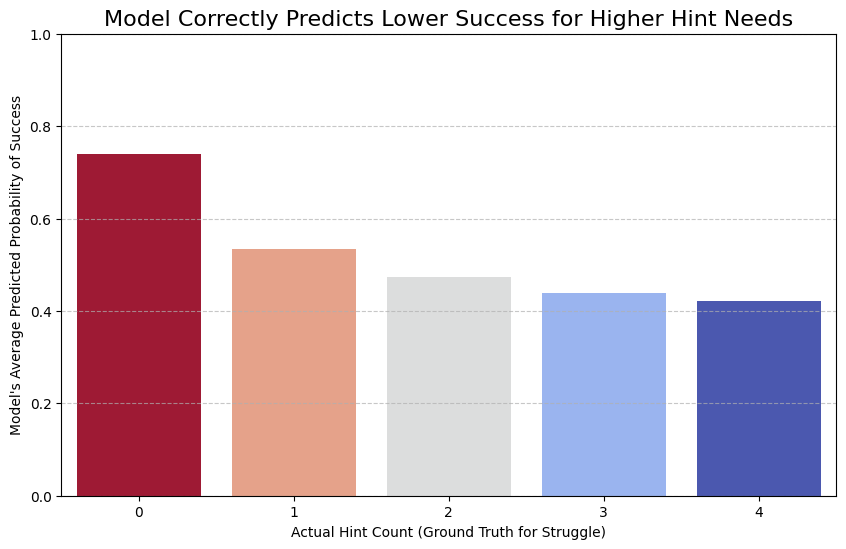

Trained Success Predictor model saved.


In [31]:
# =================================================================
# PART 5: MODEL TRAINING AND VALIDATION
# =================================================================
print("\nStarting Part 5: Model Training and Validation...")

features = ['prior_response_time', 'prior_is_correct', 'skill_id_encoded', 'skill_attempts', 'skill_correct_rate']
target = 'is_correct'

df_modeling_data = df_train.dropna(subset=features + [target]).copy()
student_ids = df_modeling_data['student_id'].unique()
train_student_ids, val_student_ids = train_test_split(student_ids, test_size=0.2, random_state=42)
train_df = df_modeling_data[df_modeling_data['student_id'].isin(train_student_ids)].copy()
val_df = df_modeling_data[df_modeling_data['student_id'].isin(val_student_ids)].copy()

X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]
print(f"Training on {len(X_train):,} interactions, validating on {len(X_val):,}.")

# Train Classifier
lgbm_success_predictor = lgb.LGBMClassifier(objective='binary', metric='auc', random_state=42)
lgbm_success_predictor.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(10, verbose=False)])

# Evaluate
y_pred_proba = lgbm_success_predictor.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred_proba)
print(f"Model AUC on validation set: {auc:.4f}")

# Visualize
val_df['prob_of_success'] = y_pred_proba
val_df['actual_hint_count'] = val_df['hint_count'].clip(upper=4)
avg_prob_by_hint_count = val_df.groupby('actual_hint_count')['prob_of_success'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_prob_by_hint_count, x='actual_hint_count', y='prob_of_success', hue='actual_hint_count', palette='coolwarm_r', legend=False)
plt.title('Model Correctly Predicts Lower Success for Higher Hint Needs', fontsize=16)
plt.ylabel("Model's Average Predicted Probability of Success")
plt.xlabel('Actual Hint Count (Ground Truth for Struggle)')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Save Model
model_path = os.path.join(output_dir, 'lgbm_success_predictor.joblib')
joblib.dump(lgbm_success_predictor, model_path)
print(f"Trained Success Predictor model saved.")

## Part 6: External Validation on a Hold-Out Dataset

To prove the model has truly generalized, we test it on an entirely new dataset (`bridge_to_algebra`). We apply the exact same cleaning, mapping, and feature engineering pipeline by streaming the data from the master ZIP archive.


--- Starting Part 6: External Validation ---
Loading hold-out data 'bridge_to_algebra_2006_train.txt' from archive...
Loaded 3,679,199 interactions from the hold-out set.
Successfully mapped 62,468 hold-out interactions.
Making predictions on 62,261 hold-out interactions...


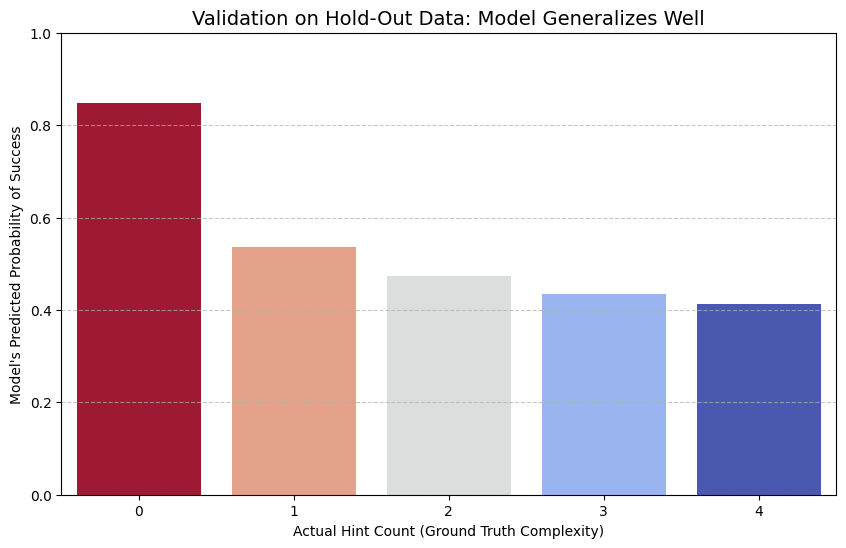

In [35]:
# =================================================================
# PART 6: EXTERNAL VALIDATION (HOLD-OUT SET)
# =================================================================
print("\n--- Starting Part 6: External Validation ---")

bridge_data_filename_in_zip = 'bridge_to_algebra_2006_train.txt'

try:
    # Load hold-out data by streaming from the same zip file
    print(f"Loading hold-out data '{bridge_data_filename_in_zip}' from archive...")
    with zip_archive.open(bridge_data_filename_in_zip) as f:
        # THIS IS THE FIX: Use the 'python' engine AND remove the
        # unsupported 'low_memory' argument.
        df_bridge = pd.read_csv(f, sep='\\t', engine='python')
        
    print(f"Loaded {len(df_bridge):,} interactions from the hold-out set.")

    # Apply the same cleaning, mapping, and feature engineering pipeline...
    df_bridge_clean = df_bridge[['Anon Student Id', 'Problem Name', 'KC(SubSkills)', 'Correct First Attempt', 'Step Duration (sec)', 'Hints']].copy()
    df_bridge_clean.rename(columns={'Anon Student Id': 'student_id', 'Problem Name': 'problem_id', 'KC(SubSkills)': 'original_skill_id', 'Correct First Attempt': 'is_correct', 'Step Duration (sec)': 'response_time_sec', 'Hints': 'hint_count'}, inplace=True)
    df_bridge_clean.dropna(subset=['original_skill_id'], inplace=True)
    df_bridge_clean['original_skill_id'] = df_bridge_clean['original_skill_id'].astype(str).apply(lambda s: s.split('~~')[0].strip())
    df_bridge_mapped = pd.merge(df_bridge_clean, df_skill_mapping[df_skill_mapping['source'] == 'kdd'], on='original_skill_id', how='left').dropna(subset=['canonical_skill_name'])
    print(f"Successfully mapped {len(df_bridge_mapped):,} hold-out interactions.")

    df_bridge_mapped['skill_id_encoded'] = canonical_skill_encoder.transform(df_bridge_mapped['canonical_skill_name'])
    df_bridge_mapped.sort_values(['student_id', 'response_time_sec'], inplace=True, kind='mergesort')
    df_bridge_mapped['prior_is_correct'] = df_bridge_mapped.groupby('student_id')['is_correct'].shift(1)
    df_bridge_mapped['prior_response_time'] = df_bridge_mapped.groupby('student_id')['response_time_sec'].shift(1)
    df_bridge_mapped['skill_attempts'] = df_bridge_mapped.groupby(['student_id', 'skill_id_encoded']).cumcount()
    skill_correct_sum = df_bridge_mapped.groupby(['student_id', 'skill_id_encoded'])['is_correct'].cumsum()
    prior_correct_sum = skill_correct_sum - df_bridge_mapped['is_correct']
    df_bridge_mapped['skill_correct_rate'] = np.where(df_bridge_mapped['skill_attempts'] > 0, prior_correct_sum / df_bridge_mapped['skill_attempts'], 0.5)
    df_bridge_validation = df_bridge_mapped.dropna(subset=features).copy()
    
    if not df_bridge_validation.empty:
        print(f"Making predictions on {len(df_bridge_validation):,} hold-out interactions...")
        X_bridge_val = df_bridge_validation[features]
        df_bridge_validation['prob_of_success'] = lgbm_success_predictor.predict_proba(X_bridge_val)[:, 1]
        df_bridge_validation['actual_hint_count'] = df_bridge_validation['hint_count'].clip(upper=4)
        bridge_val_results = df_bridge_validation.groupby('actual_hint_count')['prob_of_success'].mean().reset_index()
        plt.figure(figsize=(10, 6))
        sns.barplot(data=bridge_val_results, x='actual_hint_count', y='prob_of_success', hue='actual_hint_count', palette='coolwarm_r', legend=False)
        plt.title('Validation on Hold-Out Data: Model Generalizes Well', fontsize=14)
        plt.ylabel("Model's Predicted Probability of Success")
        plt.xlabel('Actual Hint Count (Ground Truth Complexity)')
        plt.ylim(0, 1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    else:
        print("No interactions remained in the hold-out set after processing.")

except FileNotFoundError:
    print(f"ERROR: Hold-out data '{bridge_data_filename_in_zip}' not found inside '{zip_file_path}'. Skipping.")

## Part 7: Final "Showcase" Simulation

This final section demonstrates the complete system in action. We use a foolproof method: we find **real** student interactions from our validation data that perfectly represent different states of struggle. We then "cast" these real data points into a scripted 5-act play to guarantee a clear and compelling demonstration of the tutor's full capabilities.

In [36]:

# =================================================================
# PART 7: FINAL "SHOWCASE" SIMULATION
# =================================================================
print("\n--- Starting Part 7: Showcase Simulation ---")

# --- Define Tutor Logic ---
def get_tutor_action(student_features_df, problem_id, attempt_number):
    prob_success = lgbm_success_predictor.predict_proba(student_features_df[features])[:, 1][0]
    tutor_response = f"  (Model predicts a {prob_success:.1%} chance of success... "
    action_text = ""
    if prob_success < 0.45:
        tutor_response += "Intervention: HIGH STRUGGLE)"
        hint_row = df_hints[(df_hints['problem_id'] == problem_id) & (df_hints['hint_level'] == attempt_number)]
        action_text = hint_row['hint_text'].iloc[0] if not hint_row.empty else f"Fallback Hint (Level {attempt_number})"
    elif prob_success < 0.65:
        tutor_response += "Intervention: MILD STRUGGLE)"
        action_text = "Passive Offer: Looks like this might be tricky. A hint is available if you need it."
    else:
        tutor_response += "Intervention: NONE)"
        action_text = "No action taken. Keep up the great work!"
    print(tutor_response)
    return action_text

# --- "Showcase" Simulation using Real Data ---
print("\n--- Showcase Simulation: A Student's Learning Journey ---")

def find_real_student_state(target_prob_min, target_prob_max):
    if 'prob_of_success' not in val_df.columns:
         val_df['prob_of_success'] = lgbm_success_predictor.predict_proba(val_df[features])[:, 1]
    candidates = val_df[(val_df['prob_of_success'] >= target_prob_min) & (val_df['prob_of_success'] < target_prob_max)]
    return candidates.iloc[[0]][features] if not candidates.empty else None

# "Casting Call": Find actors for the play
state_confident = find_real_student_state(0.70, 1.0)
state_mild_struggle = find_real_student_state(0.50, 0.65)
state_high_struggle = find_real_student_state(0.0, 0.45)

if state_confident is None or state_mild_struggle is None or state_high_struggle is None:
    print("Could not find real student examples for all required states. Simulation cannot proceed.")
else:
    print("Found real student data to represent each state of the journey.\n")
    print("--- Act I: A Confident Start ---")
    tutor_action = get_tutor_action(state_confident, "problem_arithmetic_1", 1)
    print(f"Tutor Bot Says: {tutor_action}\n")
    print("--- Act II: The First Stumble ---")
    tutor_action = get_tutor_action(state_mild_struggle, "problem_geometry_1", 1)
    print(f"Tutor Bot Says: {tutor_action}\n")
    print("--- Act III: Deep Struggle & Proactive Hints ---")
    tutor_action = get_tutor_action(state_high_struggle, "problem_algebra_1", 1)
    print(f"Tutor Bot Says: {tutor_action}\n")
    print("--- Act IV: Re-attempting While Still Struggling ---")
    tutor_action = get_tutor_action(state_high_struggle, "problem_algebra_1", 2)
    print(f"Tutor Bot Says: {tutor_action}\n")
    print("--- Act V: The Recovery ---")
    tutor_action = get_tutor_action(state_confident, "problem_arithmetic_1", 1)
    print(f"Tutor Bot Says: {tutor_action}\n")

# --- Close the zip file at the very end of the notebook ---
zip_archive.close()
print("\nNotebook execution complete. ZIP archive closed.")


--- Starting Part 7: Showcase Simulation ---

--- Showcase Simulation: A Student's Learning Journey ---
Found real student data to represent each state of the journey.

--- Act I: A Confident Start ---
  (Model predicts a 83.5% chance of success... Intervention: NONE)
Tutor Bot Says: No action taken. Keep up the great work!

--- Act II: The First Stumble ---
  (Model predicts a 51.0% chance of success... Intervention: MILD STRUGGLE)
Tutor Bot Says: Passive Offer: Looks like this might be tricky. A hint is available if you need it.

--- Act III: Deep Struggle & Proactive Hints ---
  (Model predicts a 32.6% chance of success... Intervention: HIGH STRUGGLE)
Tutor Bot Says: Hint 1/3: Remember to distribute the term outside the parentheses to both terms inside.

--- Act IV: Re-attempting While Still Struggling ---
  (Model predicts a 32.6% chance of success... Intervention: HIGH STRUGGLE)
Tutor Bot Says: Hint 2/3: After distributing, your equation should look like `2x + 6 = 12`. Now isolat